In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
# loading the data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train_final, x_val, y_train_final, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [25]:
def preprocess_images(images):
    # convert images to greyscale
    images_gray = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in images])

    # perform histogram equalization images
    images_equalized = np.array([cv2.equalizeHist(img) for img in images_gray])

    # normalize images using min-m normalization
    images_normalized = images_equalized / 255.0

    # expand image dimensions
    images_expanded = np.expand_dims(images_normalized, axis=-1)

    return images_expanded

In [26]:
# preoprocess training, validation, and test data
x_train_processed = preprocess_images(x_train_final)
x_val_processed = preprocess_images(x_val)
x_test_processed = preprocess_images(x_test)


In [27]:
# convert the labels to one-hot encoding
y_train_final = to_categorical(y_train_final, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [28]:
model = Sequential([
    # First Block
    Conv2D(64, (5, 5), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    MaxPooling2D(pool_size=(2, 2)),

    # Second Block
    Conv2D(128, (5, 5), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.1),

    # Third Block
    Conv2D(256, (5, 5), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    Conv2D(256, (3, 3), padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),


    # Fourth Block
    Conv2D(512, (5, 5), padding='same', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    Conv2D(512, (3, 3), padding='same', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    LeakyReLU(alpha=0.1),

    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Fully Connected Layers
    GlobalAveragePooling2D(),

    Dense(512, kernel_regularizer=l2(0.003)),
    LeakyReLU(alpha=0.1),
    Dropout(0.4),

    Dense(256, kernel_regularizer=l2(0.002)),
    LeakyReLU(alpha=0.1),
    Dropout(0.3),

    Dense(128, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    Dropout(0.2),

    Dense(10, activation='softmax')
])


In [30]:
model = load_model("model.keras")

In [31]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(x_train_processed)

In [32]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Add ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-6
)

# checkpoint for saving best model
checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True)

In [33]:
# compiling the new model
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [34]:
# training the new model
history = model.fit(
    datagen.flow(x_train_processed, y_train_final, batch_size=32),
    validation_data=(x_val_processed, y_val),
    epochs=100,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


In [35]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(x_test_processed, y_test, verbose=2)
print(f"Test Accuracy: {test_accuracy:.4f}")

313/313 - 32s - 102ms/step - accuracy: 0.8647 - loss: 0.6050
Test Accuracy: 0.8647


In [37]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (32, 32, 32, 64)       │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (32, 32, 32, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (32, 32, 32, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (32, 32, 32, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (32, 32, 32, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (32, 32, 32, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 16, 16, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (32, 16, 16, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (32, 16, 16, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (32, 16, 16, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (32, 16, 16, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (32, 16, 16, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (32, 16, 16, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 8, 8, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (32, 8, 8, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (32, 8, 8, 256)        │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (32, 8, 8, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (32, 8, 8, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (32, 8, 8, 256)        │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (32, 8, 8, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (32, 8, 8, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (32, 4, 4, 256)        │             

 Total params: 7,873,610 (30.04 MB)

 Trainable params: 7,869,770 (30.02 MB)

 Non-trainable params: 3,840 (15.00 KB)

313/313 - 29s - 94ms/step - accuracy: 0.8647 - loss: 0.6050
Test Loss: 0.6050
Test Accuracy: 0.8647
313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step

Classification Report:
              precision    recall  f1-score   support

    airplane       0.78      0.93      0.85      1000
  automobile       0.93      0.96      0.95      1000
        bird       0.76      0.85      0.80      1000
         cat       0.79      0.73      0.76      1000
        deer       0.85      0.83      0.84      1000
         dog       0.89      0.72      0.80      1000
        frog       0.86      0.89      0.87      1000
       horse       0.93      0.90      0.91      1000
        ship       0.93      0.92      0.93      1000
       truck       0.96      0.92      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



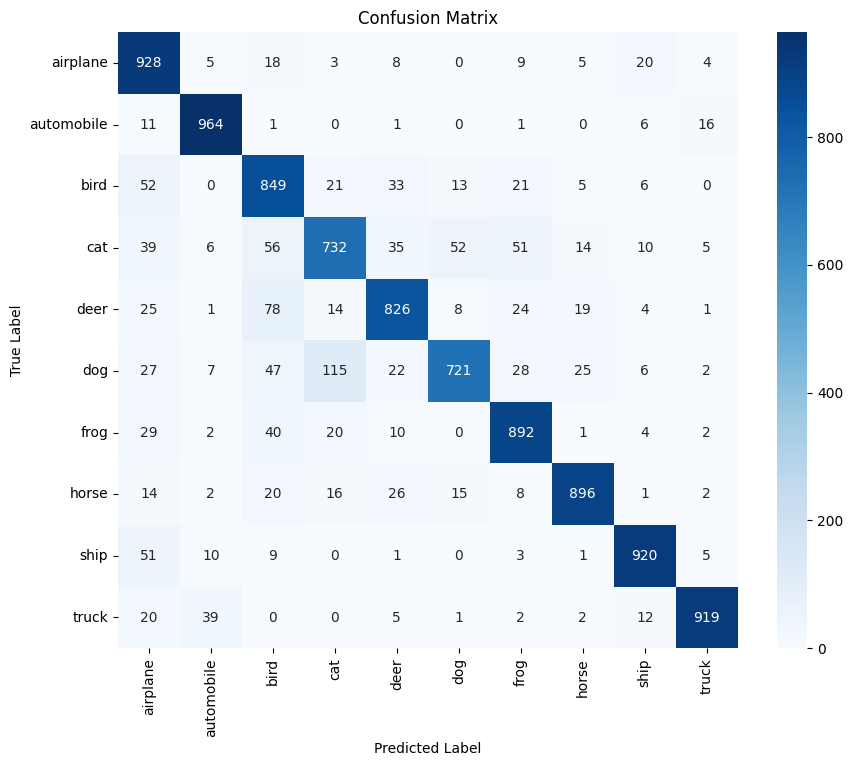

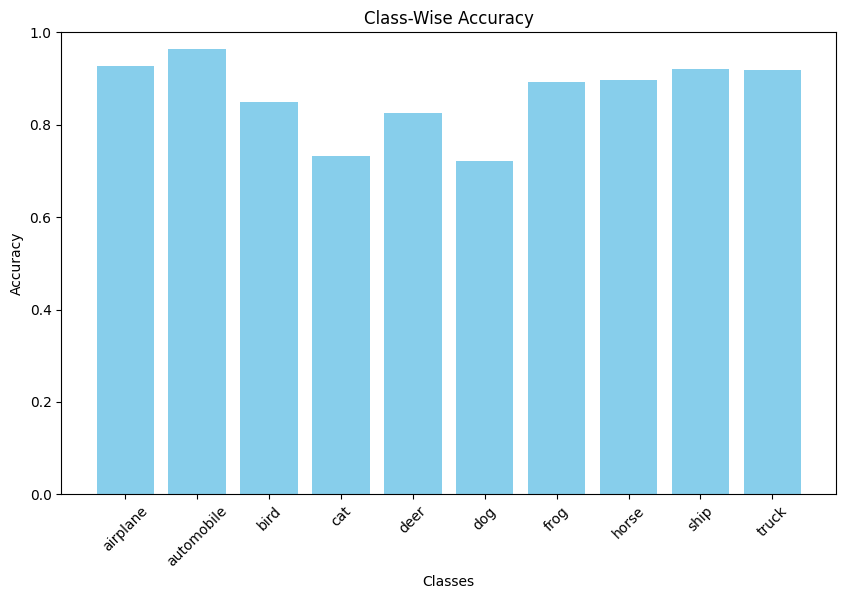

In [ ]:
# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_test_processed, y_test, verbose=2)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict class probabilities and convert to predicted labels
y_pred_probs = model.predict(x_test_processed)
y_pred = np.argmax(y_pred_probs, axis=1)  # Get class indices of predictions
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to integers

# Generate Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Generate and Visualize Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Additional Metrics Visualization
# Calculate accuracy per class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

# Visualize Class-Wise Accuracy
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_accuracy, color='skyblue')
plt.title("Class-Wise Accuracy")
plt.xlabel("Classes")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.xticks(rotation=45)
plt.show()